# Lab 7 - Meotdy Sztucznej Inteligencji
## Autor: Dominik Pabiniak, 254397

##### Przeczytaj załączony artykuł i w oparciu o informacje w nim zawarte oraz inne artykuły z tego obszaru zaimplementuj Fuzzy SVM. Użyj go do rozwiązania wybranego problemu klasyfikacji. Porównaj wyniki z klasycznym SVM.

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def sensitivity(m_p):
    return round((m_p[0][0]/(m_p[0][0] + m_p[0][1])), 4)
def specificity(m_p):
    return round((m_p[1][1]/(m_p[1][0] + m_p[1][1])), 4)

def plot_class(X_syn_test, y_pred, model, method):
        X_pred_0 = X_syn_test[y_pred == 0]
        X_pred_1 = X_syn_test[y_pred == 1]
        x_min, x_max = X_syn_test[:, 0].min() - 0.2, X_syn_test[:, 0].max() + 0.2
        y_min, y_max = X_syn_test[:, 1].min() - 0.2, X_syn_test[:, 1].max() + 0.2
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.2)
        plt.scatter(X_pred_0[:, 0], X_pred_0[:, 1], marker='.', label='Klasa 1')
        plt.scatter(X_pred_1[:, 0], X_pred_1[:, 1], marker='.', label='Klasa 2')
        plt.title(f'Powierzchnia decyzyjna {method}')
        plt.xlabel('Cecha 1')
        plt.ylabel('Cecha 2')
        plt.legend()

In [48]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import random

X_m, y_m = make_moons(n_samples=50, random_state=254397, noise=0.2)
s_m = [random.random() for x, y in zip(X_m, y_m)]

In [35]:
import numpy as np

from sklearn.model_selection import train_test_split
from scipy.sparse import issparse
from scipy.optimize import minimize
from numpy.random import RandomState
from itertools import product
from scipy.optimize import LinearConstraint


class FuzzySVM():

    def __init__(self, C=1, kernel='linear', degree=3, coef0=0, gamma=1,
                 max_samples=100, tol=None, max_iter=10, random_state=254397, disp=False):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.coef0 = coef0
        self.gamma = gamma
        self.max_samples = max_samples
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
        self.disp = disp

        self.kernel_fun = self._get_kernel(kernel)
        self.rs = RandomState(random_state)

        self.alphas = None
        self.X = None
        self.y = None
        self.b = None

    def fit(self, X, ys):
        y = ys[:, 0]
        s = ys[:, 1] # sample weights (fuzzy membership)

        # replaces 0 labels with -1
        y = y.flatten()
        y = np.copy(y)
        y[y == 0] = -1

        # minimization
        initial_alphas = np.repeat(0, X.shape[0])
        alphas_bounds = [(0, s[i] * self.C) for i in range(X.shape[0])]
        constraint1 = LinearConstraint(y, 0, 0)
        res = minimize(
            self._loss,
            initial_alphas,
            method='trust-constr',
            args=(X, y, self.kernel_fun),
            bounds=alphas_bounds,
            constraints=(constraint1,),
            tol=self.tol,
            options={'maxiter': self.max_iter, 'disp': self.disp}
        )
        alphas = res.x.ravel()

        # save results
        self.alphas = alphas
        self.X = X
        self.y = y
        self.b = self._calc_bias(alphas, y, X, self.kernel_fun)

        return self


    def _loss(self, alpha, X, ys, kernel_fun):
        """
        Calculate loss according to maximization of W(alpha) in article. To minimize this we should do -max
        """
        alphas = alpha.flatten()
        n = alphas.size

        s = 0
        for i, j in product(range(n), range(n)):
            s += alphas[i]*alphas[j]*ys[i]*ys[j]*kernel_fun(X[i], X[j])
        return 0.5 * s - np.sum(alphas)

    def _calc_bias(self, alphas, ys, xs, kernel_fun):
        n = xs.shape[0]
        bias_sum = 0
        for i in range(n):
            bias_part = ys[i] - sum((alphas[j] * ys[j] * kernel_fun(xs[i], xs[j]) for j in range(n)))
            bias_sum += bias_part
        return bias_sum / n

    def _get_kernel(self, kernel_name):
        if kernel_name == 'linear':
            return self._kernel_linear
        elif kernel_name == 'poly':
            return self._kernel_poly
        elif kernel_name == 'rbf':
            return self._kernel_rbf

    def _kernel_linear(self, a, b):
        return a @ b

    def _kernel_poly(self, a, b):
        return (a @ b + self.coef0) ** self.degree

    def _kernel_rbf(self, a, b):
        return np.exp(-self.gamma * np.sqrt((a-b) @ (a-b)))

    def decision_function(self, X):
        n = self.X.shape[0]
        kernel_fun = np.vectorize(self.kernel_fun, signature='(n),(n)->()')
        sum_parts = (self.alphas[i] * self.y[i] * kernel_fun(self.X[i], X) for i in range(n))
        sum_value = sum(sum_parts)
        result = sum_value + self.b
        return result

    def predict(self, X):
        return self.decision_function(X) > 0

In [36]:
from scipy.optimize import minimize
from itertools import product
from scipy.optimize import LinearConstraint


class MSVC():
    def __init__(self, C=1, kernel='linear', degree=3, gamma=1,
                tol=None, max_iter=10):
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.tol = tol
        self.max_iter = max_iter
        
        self.alphas = None
        self.X = None
        self.y = None
        self.b = None

    def fit(self, X, y):
        y[y == 0] = -1
        initial_alphas = np.repeat(0, X.shape[0])
        alphas_bounds = [(0, np.inf) for _ in range(X.shape[0])]
        constraint1 = LinearConstraint(y, 0, 0)
        constraint2 = LinearConstraint(np.ones((X.shape[0],)), 0, self.C)

        res = minimize(
            self._loss,
            initial_alphas,
            method='trust-constr',
            args=(X, y, self._kernel_matrix),
            bounds=alphas_bounds,
            constraints=(constraint1, constraint2),
            tol=self.tol,
            options={'maxiter': self.max_iter}
        )

        alphas = res.x

        self.alphas = alphas
        self.X = X
        self.y = y
        self.b = self._calc_bias(alphas, y, X)
    
    def _loss(self, alphas, X, y, kernel_fun):
        n = alphas.size
        L = 0
        for i, j in product(range(n), range(n)):
            L += -alphas[i] + 0.5*(alphas[i]*alphas[j]*y[i]*y[j]*kernel_fun(X[i], X[j]))
        return L

    
    def _calc_bias(self, alphas, ys, xs):
        n = xs.shape[0]
        bias_sum = 0
        for i in range(n):
            bias_part = ys[i] - sum((alphas[j] * ys[j] * self._kernel_matrix(xs[i], xs[j]) for j in range(n)))
            bias_sum += bias_part
        return bias_sum / n
    

    def _kernel_matrix(self, A, B):
        if self.kernel == 'rbf':
            return self._rbf_kernel(A, B)
        elif self.kernel == 'poly':
            return self._poly_kernel(A, B)
        elif self.kernel == 'linear':
            return self._linear_kernel(A, B)
        else:
            raise ValueError("Kernel not supported")
    
    def _linear_kernel(self, A, B):
        return A @ B

    def _poly_kernel(self, A, B):
        return (A @ B + 1) ** self.degree
    
    def _rbf_kernel(self, A, B):
        return np.exp(-self.gamma*np.sqrt((A-B)@(A-B)))

    def decision_function(self, X):
        n = self.X.shape[0]
        kernel_fun = np.vectorize(self._kernel_matrix, signature='(n),(n)->()')
        sum_parts = (self.alphas[i] * self.y[i] * kernel_fun(self.X[i], X) for i in range(n))
        sum_value = sum(sum_parts)
        result = sum_value + self.b
        return result

    def predict(self, X):
        return self.decision_function(X) > 0

In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from time import time

fuzzy_svm = make_pipeline(
    FuzzySVM(kernel='poly', degree=3, coef0=1, C=50, max_samples=70, max_iter=400, tol=1e-20)
)

start = time()
fuzzy_svm.fit(X_m, np.column_stack([y_m, s_m]))
print(f'Fit time (Fuzzy): {time()-start:.2f}')

c:\Users\Dominik\anaconda3\envs\cuda_env\Lib\site-packages\scipy\optimize\_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


Fit time (Fuzzy): 58.69


In [38]:
model = make_pipeline(
    MSVC(
        kernel='poly',
        degree=3,
        C=50,
        max_iter=400,
        tol=1e-20
    )
)

start = time()
model.fit(X_m, y_m)
print(f'Fit time (Regular): {time()-start:.2f}')

Fit time (Regular): 72.83


Accuracy fuzzy: 0.98
Accuracy regular: 1.0


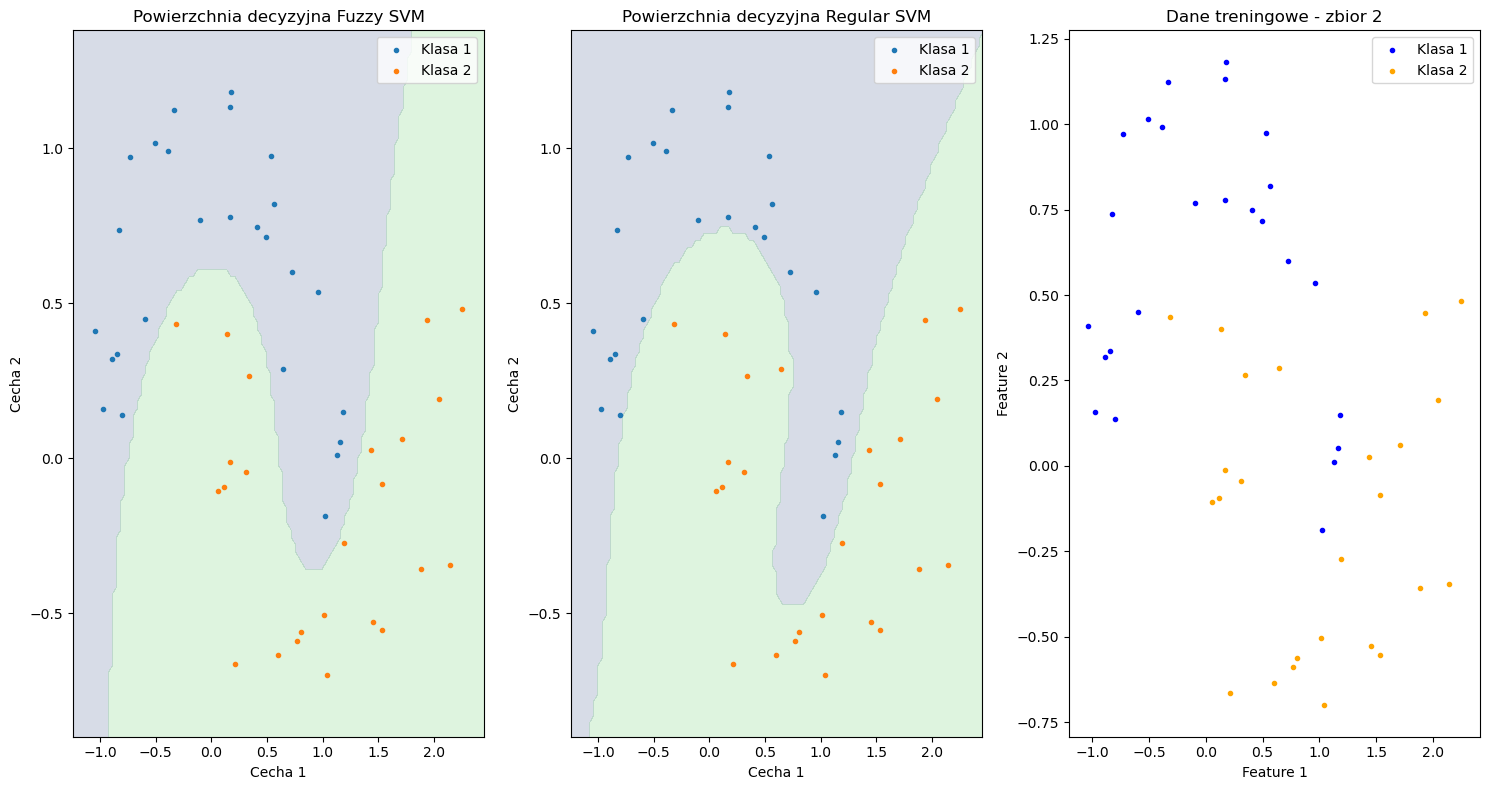

In [50]:
from sklearn.metrics import accuracy_score

y_pred = fuzzy_svm.predict(X_m)
y_pred_regular = model.predict(X_m)

klasa_0 = X_m[(y_m == 0)]
klasa_1 = X_m[(y_m == 1)]

print(f'Accuracy fuzzy: {accuracy_score(y_pred, y_m)}\nAccuracy regular: {accuracy_score(y_pred_regular, y_m)}')

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plot_class(X_m, y_pred, fuzzy_svm, 'Fuzzy SVM')
plt.subplot(1, 3, 2)
plot_class(X_m, y_pred_regular, model, 'Regular SVM')
plt.subplot(1, 3, 3)
plt.scatter(klasa_0[:, 0], klasa_0[:, 1], c="blue", label="Klasa 1", marker='.')
plt.scatter(klasa_1[:, 0], klasa_1[:, 1], c="orange", label="Klasa 2", marker='.')
plt.title("Dane treningowe - zbior 2")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()